### Only focus on model
- things matter end result: train_test_split portion, dependent variables for prediction (unit price vs total price), model parameters
- mainly using lightgbm testing different combination
- result record in [here](https://docs.google.com/spreadsheets/d/1WaLDSYc89plQ_um0mpxMoPjoRlX8iXUhy-nBGzTV6U8/edit?usp=sharing)

In [1]:
#--- import some necessary librairies

import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from scipy.special import boxcox1p,inv_boxcox1p
from scipy.stats import boxcox_normmax,boxcox

from subprocess import check_output
from sklearn.externals import joblib

In [2]:
train = pd.read_csv('/Users/chloe/Google Drive/Kaggle_Data/tbrain_yushan_house_price_prediction/train.csv')
test = pd.read_csv('/Users/chloe/Google Drive/Kaggle_Data/tbrain_yushan_house_price_prediction/test.csv')

In [3]:
train["unit_price"] = train["total_price"]/train["building_area"]

In [4]:
test_building_id = test.building_id.values

In [5]:
y_train = train.unit_price.values
y_price = train.total_price.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['total_price'], axis=1, inplace=True)
all_data.drop(['unit_price'], axis=1, inplace=True)

del all_data["building_id"]
print("all_data size is : {}".format(all_data.shape))

all_data size is : (70000, 233)


### Deal with missing value & change categorical variable

In [6]:
all_data.isnull().sum().sort_values(ascending=False)[:4]

parking_area             66397
parking_price            53775
txn_floor                18541
village_income_median     1326
dtype: int64

In [7]:
# fill in missing value
del all_data["parking_area"]
all_data["txn_floor"] = all_data["txn_floor"].fillna(0)
all_data["parking_price"] = all_data["parking_price"].fillna(0)
all_data['village_income_median'] = all_data['village_income_median'].fillna(all_data['village_income_median'].mean())

In [8]:
# add features [v2]

all_data["ratio_floor"] = all_data["txn_floor"]/all_data["total_floor"]
all_data["top_floor"] = np.where(all_data["txn_floor"]==all_data["total_floor"],1,0)
all_data["perc_land"] =  all_data["land_area"]/all_data["building_area"]

In [9]:
# add features [v3]
main_col = ["village_income_median", "town_population", "town_area",
            "city", "town", "village","land_area", "building_area"] 
interact_col = [col for col in all_data.columns if re.search("[a-zA-Z]_rate$", col, re.IGNORECASE)!=None]

for m_col in main_col:
    for i_col in interact_col:
        all_data[m_col+"_"+i_col+"_IT"] = all_data[m_col]*all_data[i_col]  
        
for col in interact_col:
    all_data[col+"_s"] = all_data[col]**2
    

all_data["ratio_parking_price"] = all_data["parking_price"]/all_data["village_income_median"]
all_data["good_factor"] = all_data["marriage_rate"]+all_data["master_rate"]+all_data["bachelor_rate"]
all_data["good_factor"+"_s"] = all_data["good_factor"]**2

### train model

In [10]:
train = all_data[:len(train)]
test = all_data[len(train):]

In [13]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.svm import SVR

In [14]:
#--- Evaluation metric

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def MAPE(y, y_pred):
    return sum(abs(y_pred-y)/y)/len(y)

def Score(y, y_pred):
    y=np.expm1(y)
    y_pred=np.expm1(y_pred)
    hit_rate = np.around(np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/len(y),decimals=4)*10000
    MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    return hit_rate+MAPE

def Score_MAPE(y, y_pred):
    y=np.expm1(y)
    y_pred=np.expm1(y_pred)
    MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    return MAPE

# archive
def Score_type(y, y_pred, h_type):
    y = np.expm1(y)
    y_pred = np.where(h_type>0,np.expm1(y_pred),0)
    hit_rate = np.around(np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/len(y),decimals=4)*10000
    MAPE = 1-np.sum(abs((y_pred-y)/y))/len(y)
    return hit_rate+MAPE

# archive
def Score_acc(y, y_pred, h_type):
    y = np.expm1(y)
    y_pred = np.where(h_type>0,np.expm1(y_pred),0)
    type_total = sum(np.where(h_type>0,1,0))
    hit_rate = np.sum(np.where(abs((y_pred-y)/y)<.1,1,0))/type_total
    return hit_rate#+MAPE

In [15]:
X_train, X_valid, train_y, valid_y = train_test_split(train, np.log1p(y_train), test_size=0.1, random_state= 0)

In [16]:
# # model 0
# gbm = lgb.LGBMRegressor()

In [17]:
# # model 1 
# gbm = lgb.LGBMRegressor(objective='regression',
#                         num_leaves=80,
#                         learning_rate=0.03,
#                         n_estimators=6769,
#                        colsample_bytree = 0.6886781648348815,
#                        max_depth = 18,
#                        subsample = 0.7241144257909466)

In [18]:
# model 2
gbm = lgb.LGBMRegressor(objective='regression',
                        metric='mape',
                        num_leaves=80,
                        learning_rate=0.03,
                        n_estimators=6769,
                       colsample_bytree = 0.6886781648348815,
                       max_depth = 18,
                       subsample = 0.7241144257909466)

In [19]:
gbm.fit(X_train, train_y)
y_pred = gbm.predict(X_valid)

In [20]:
# # show feature importance
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(gbm, random_state=0).fit(X_valid, valid_y)
# eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

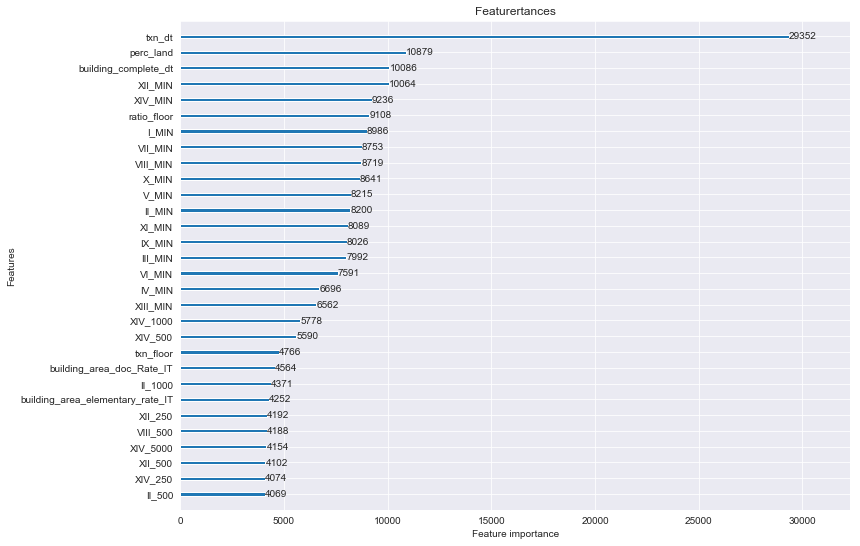

In [21]:
# lgbm inbuilt feature importance
lgb.plot_importance(gbm, max_num_features=30,figsize=(12,9))

plt.title("Featurertances")
plt.show()

In [22]:
print("Score:", Score(valid_y, y_pred))
print("Loss:", rmsle(valid_y, y_pred))

Score: 5833.873581782972
Loss: 0.18806925043899178


In [23]:
# submit
y_pred_final = gbm.predict(test)
y_final = np.expm1(y_pred_final)

In [34]:
submission = pd.DataFrame()
submission["prediction"] = y_final*test["building_area"]
submission["building_id"] = test_building_id
submission = submission[["building_id", "prediction"]]

In [37]:
submission.head(5)

,building_id,prediction
60000,X5gsdTWGS3W7JJQB,11937084.005
60001,BTshNOJyKHnT2YIT,3985554.538
60002,dhdymr0lV8N5kZOT,11013934.368
60003,VEwyGGMcD56w5BOc,6109854.641
60004,wmUeMoJZfsqaSX9b,1148999.586
